In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import scipy.io
from scipy.signal import butter, lfilter
import scipy.signal

In [2]:
# Load DEAP dataset (Change path accordingly)
data_path = "E:/FYP/Finalise Fyp/EEg-based-Emotion-Recognition/data_preprocessed_matlab/"
subject_data = []
subject_labels = []

# Load all 32 subjects
for i in range(1, 33):
    mat = scipy.io.loadmat(f"{data_path}s{i:02d}.mat")
    
    # Extract EEG data and labels
    subject_data.append(mat["data"])     # Shape: (40 trials, 40 channels, 8064 samples)
    subject_labels.append(mat["labels"]) # Shape: (40 trials, 4 labels)

# Convert lists to NumPy arrays
subject_data = np.array(subject_data)     # Expected Shape: (32, 40, 40, 8064)
subject_labels = np.array(subject_labels) # Expected Shape: (32, 40, 4)

# Print shapes to confirm
print("EEG Data Shape:", subject_data.shape)   # (32, 40, 40, 8064)
print("Labels Shape:", subject_labels.shape)   # (32, 40, 4)


EEG Data Shape: (32, 40, 40, 8064)
Labels Shape: (32, 40, 4)


In [3]:
import numpy as np
import scipy.signal
# Frequency band definitions
freq_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 14),
    "beta": (14, 30),
    "gamma": (31, 50),
}

# Define function to compute Differential Entropy (DE)
def compute_de(signal):
    """Compute Differential Entropy (DE) for a given EEG segment"""
    variance = np.var(signal, axis=-1, keepdims=True)  # Compute variance
    de = 0.5 * np.log(2 * np.pi * np.e * variance)  # Apply DE formula
    return de.squeeze()  # Remove extra dimensions

# Define function to extract DE features
def extract_de_features(subject_data, fs=128, window_size=128):
    """
    Extract DE features from EEG data.
    - subject_data: EEG data of shape (32, 40, 40, 8064)
    - fs: Sampling frequency (128 Hz)
    - window_size: 1 second (128 samples)
    Returns: DE feature array of shape (32, 40, 40, 5, 63)
    """
    num_subjects, num_trials, num_channels, num_samples = subject_data.shape
    num_bands = len(freq_bands)
    num_windows = num_samples // window_size  # 8064 / 128 = 63 windows

    # Initialize DE feature array
    de_features = np.zeros((num_subjects, num_trials, num_channels, num_bands, num_windows))

    # Loop through subjects, trials, and channels
    for subj in range(num_subjects):
        for trial in range(num_trials):
            for ch in range(num_channels):
                # Extract single-channel EEG data for this trial
                signal = subject_data[subj, trial, ch, :]

                # Apply bandpass filters and compute DE for each frequency band
                for b_idx, (band, (low, high)) in enumerate(freq_bands.items()):
                    # Bandpass filter
                    sos = scipy.signal.butter(4, [low, high], btype="bandpass", fs=fs, output="sos")
                    filtered_signal = scipy.signal.sosfilt(sos, signal)

                    # Segment into 1-second windows (128 samples each)
                    segmented = np.array(np.split(filtered_signal, num_windows, axis=-1))

                    # Compute DE for each window
                    de_features[subj, trial, ch, b_idx, :] = compute_de(segmented)

    return de_features

# Extract DE features
de_features = extract_de_features(subject_data)

# Print shape to confirm
print("DE Feature Shape:", de_features.shape)  # Expected: (32, 40, 40, 5, 63)

DE Feature Shape: (32, 40, 40, 5, 63)


In [4]:
print(type(de_features))  # Should be <class 'numpy.ndarray'>, NOT a tensor


<class 'numpy.ndarray'>


In [5]:
import numpy as np

def normalize_de_features(de_features):
    """
    Normalize DE features using Z-score normalization.
    Ensures compatibility with NumPy arrays.
    """
    de_features = np.array(de_features)  # Ensure NumPy format
    print("Normalization Step - Shape:", de_features.shape)  # Debugging

    # Compute mean and std deviation across subjects & trials (axes 0,1), not windows
    mean = np.mean(de_features, axis=(0, 1), keepdims=True)  
    std = np.std(de_features, axis=(0, 1), keepdims=True)  

    return (de_features - mean) / (std + 1e-6)  # Normalize & avoid division by zero

# Apply normalization
de_features = normalize_de_features(de_features)

# Print shape to confirm
print("Normalized DE Feature Shape:", de_features.shape)  # Should remain (32, 40, 40, 5, 63)


Normalization Step - Shape: (32, 40, 40, 5, 63)
Normalized DE Feature Shape: (32, 40, 40, 5, 63)


In [6]:
### Reshaping defeatures

from sklearn.decomposition import PCA

# Reshape DE features to (1280, 12600)
reshaped_features = de_features.reshape(-1, 12600)  

# Apply PCA with the desired feature size (e.g., 500 instead of 200)
pca = PCA(n_components=1000)
pca_features = pca.fit_transform(reshaped_features)  # Shape: (1280, 500)

# Reshape back to (32, 40, 500)
pca_features = pca_features.reshape(32, 40, 1000)

# Print shape to confirm
print("PCA Reduced Feature Shape:", pca_features.shape)  # Expected: (32, 40, 500)


PCA Reduced Feature Shape: (32, 40, 1000)


In [7]:
print("Explained variance by first 1000 components:", sum(pca.explained_variance_ratio_))


Explained variance by first 1000 components: 0.9912188717759449


**COMMON FEATURE EXTRACTION**

In [8]:
#1. Common Feature Extractor (CFE)
class CommonFeatureExtractor(nn.Module):
    def __init__(self, input_dim=1000, output_dim=64):
        super(CommonFeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, output_dim)
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

**CHECKING CFE IMPLEMENTATION**

In [9]:
# Generate random input matching PCA-reduced feature size
test_input = torch.randn(32, 40, 1000)  # Batch of 32 subjects, 40 trials each

# Initialize CFE model
cfe = CommonFeatureExtractor(input_dim=1000, output_dim=64)

# Forward pass
output = cfe(test_input.view(-1, 1000))  # Flatten batch & trials

# Check output shape
print("Input Shape:", test_input.shape)    # Expected: (32, 40, 500)
print("Output Shape:", output.shape)       # Expected: (32*40, 64) → (1280, 64)


Input Shape: torch.Size([32, 40, 1000])
Output Shape: torch.Size([1280, 64])


In [10]:
print("Any NaN in Output?:", torch.isnan(output).any().item())
print("Any Inf in Output?:", torch.isinf(output).any().item())
print("Mean of Output Features:", output.mean().item())
print("Std Dev of Output Features:", output.std().item())


Any NaN in Output?: False
Any Inf in Output?: False
Mean of Output Features: 0.049329858273267746
Std Dev of Output Features: 0.38756051659584045


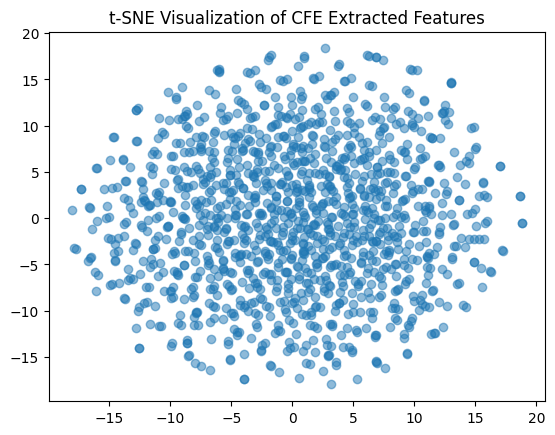

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert tensor to numpy
features = output.detach().cpu().numpy()

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)

# Scatter plot
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.5)
plt.title("t-SNE Visualization of CFE Extracted Features")
plt.show()


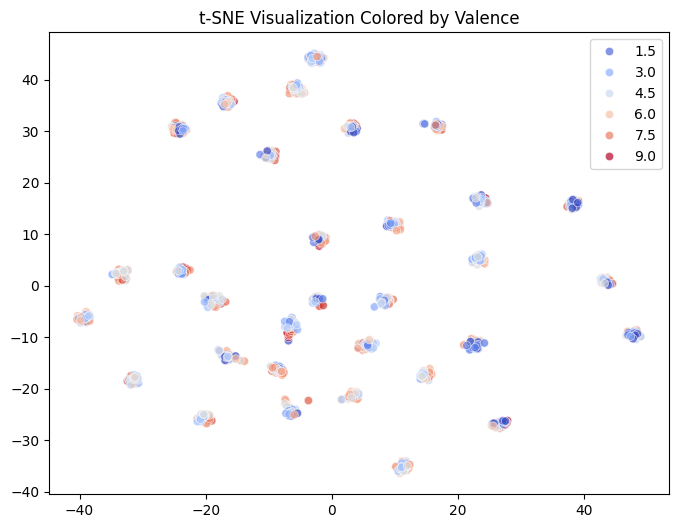

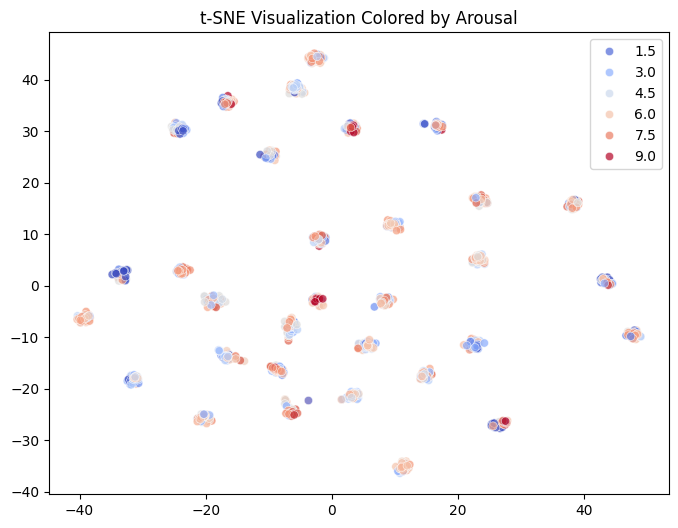

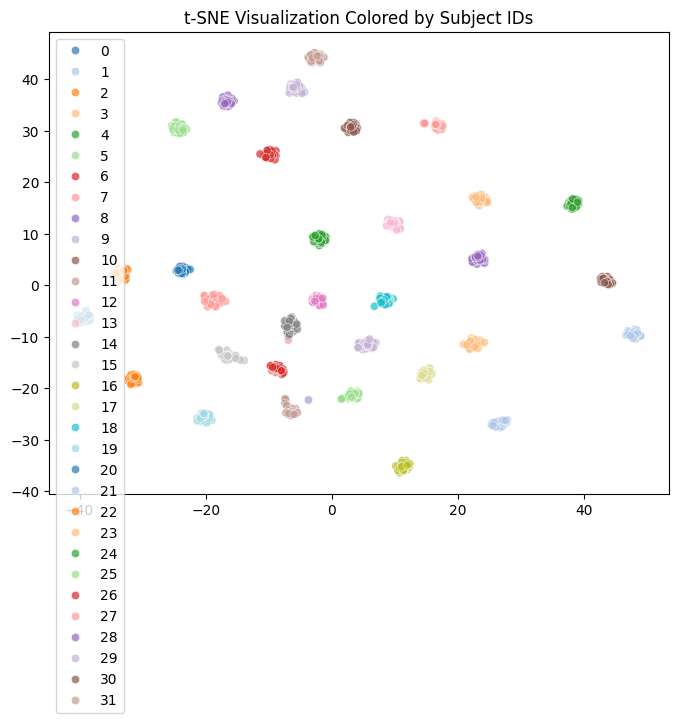

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

# Assuming pca_features has shape (32, 40, 500)
reshaped_pca_features = pca_features.reshape(1280, -1)  # Shape: (1280, 500)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, random_state=42)
tsne_results = tsne.fit_transform(reshaped_pca_features)

# Load emotion labels (valence/arousal) and subject IDs
valence_labels = subject_labels[:, :, 0].reshape(-1)  # Assuming shape (32, 40, 4), valence is first
arousal_labels = subject_labels[:, :, 1].reshape(-1)  # Arousal labels
subject_ids = np.repeat(np.arange(32), 40)  # 32 subjects, 40 trials each

# Plot t-SNE colored by Valence
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=valence_labels, palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization Colored by Valence")
plt.show()

# Plot t-SNE colored by Arousal
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=arousal_labels, palette="coolwarm", alpha=0.7)
plt.title("t-SNE Visualization Colored by Arousal")
plt.show()

# Plot t-SNE colored by Subject IDs
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=subject_ids, palette="tab20", alpha=0.7)
plt.title("t-SNE Visualization Colored by Subject IDs")
plt.show()


**CONTRASTIVE LEARNING 1**

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLossLcon1(nn.Module):
    def __init__(self, tau=0.1, supervised=False):
        super().__init__()
        self.tau = tau
        self.supervised = supervised

    def forward(self, q, labels=None):
        batch_size = q.shape[0]

        # Normalize feature vectors
        q = F.normalize(q, dim=-1)

        # Compute similarity matrix (cosine similarity)
        sim_matrix = torch.mm(q, q.T)  # (batch_size, batch_size)

        # Debugging: Check min/max similarity values
        # print("Sim Matrix min:", sim_matrix.min().item(), "Sim Matrix max:", sim_matrix.max().item())

        # Apply mask to remove self-similarity
        mask = torch.eye(batch_size, dtype=torch.bool, device=q.device)
        sim_matrix.masked_fill_(mask, float('-inf'))  # Prevent self-matching

        if self.supervised and labels is not None:
            # Find positive pairs based on labels
            label_mask = labels.unsqueeze(0) == labels.unsqueeze(1)  # (batch_size, batch_size)
            label_mask.fill_diagonal_(False)  # Remove self-similarity
        else:
            # In self-supervised mode, positive set is only the sample itself
            label_mask = torch.eye(batch_size, dtype=torch.bool, device=q.device)

        # Compute exponentiated similarity matrix (temperature scaling)
        exp_sim = torch.exp(sim_matrix / self.tau)

        # Compute denominator: sum over all elements in batch
        denom = exp_sim.sum(dim=1, keepdim=True) + 1e-9  # Avoid division by zero

        # Compute numerator: sum over positive pairs only
        num = (exp_sim * label_mask).sum(dim=1, keepdim=True) + 1e-9  # Avoid log(0)

        # Compute contrastive loss
        loss = -torch.log(num / denom).mean()

        return loss


In [14]:
import torch

# Create dummy embeddings (batch_size=4, feature_dim=64)
batch_size = 4
feature_dim = 64
tau = 0.1

# Random normalized embeddings
q = torch.randn(batch_size, feature_dim)
q = torch.nn.functional.normalize(q, dim=-1)

# Random labels (for supervised contrastive loss)
labels = torch.tensor([0, 1, 0, 1])  # Two classes (0 and 1)

# Instantiate contrastive loss function
contrastive_loss = ContrastiveLossLcon1(tau=tau, supervised=False)

# Compute loss
loss_value = contrastive_loss(q, labels)

print("Contrastive Loss L_con1:", loss_value.item())


Contrastive Loss L_con1: 22.891450881958008


**Training Contrastive Learning First**

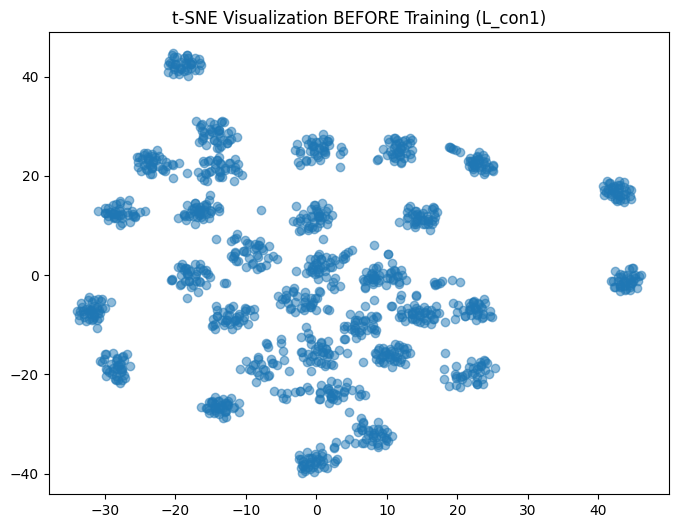

In [15]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfe = cfe.to(device)

# Convert PCA features to PyTorch tensor and RESHAPE
pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32).to(device)
pca_features_tensor = pca_features_tensor.view(-1, 1000)  # Reshape to (1280, 1000)

# Extract embeddings BEFORE training
cfe.eval()
with torch.no_grad():
    cfe_features_before = cfe(pca_features_tensor).cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features_before = tsne.fit_transform(cfe_features_before)

# Plot t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features_before[:, 0], tsne_features_before[:, 1], alpha=0.5)
plt.title("t-SNE Visualization BEFORE Training (L_con1)")
plt.show()


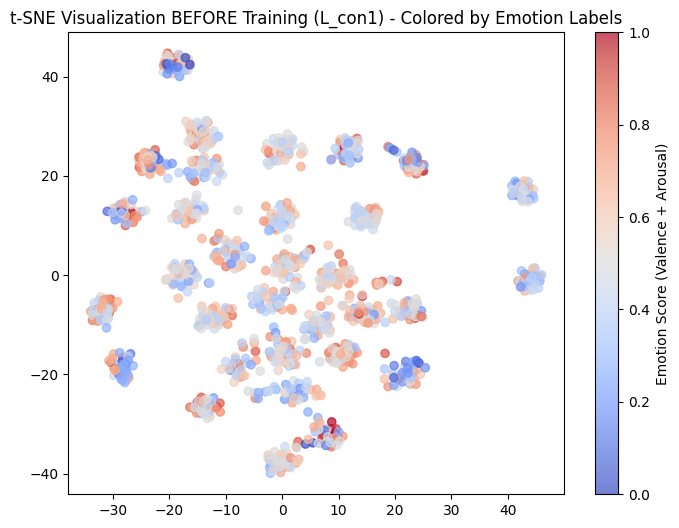

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming labels shape: (32, 40, 2) -> (valence, arousal)
# Flatten to match t-SNE input (1280,)
valence_labels = subject_labels[:, :, 0].flatten()
arousal_labels = subject_labels[:, :, 1].flatten()

# Normalize labels between 0 and 1 for color mapping
valence_norm = (valence_labels - valence_labels.min()) / (valence_labels.max() - valence_labels.min())
arousal_norm = (arousal_labels - arousal_labels.min()) / (arousal_labels.max() - arousal_labels.min())

# Combine valence & arousal for a joint color scale (averaged)
combined_labels = (valence_norm + arousal_norm) / 2

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(cfe_features_before)  # (1280, 2)

# Plot t-SNE with color-coded emotions
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=combined_labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Emotion Score (Valence + Arousal)")
plt.title("t-SNE Visualization BEFORE Training (L_con1) - Colored by Emotion Labels")
plt.show()


In [21]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert PCA features and labels to PyTorch tensors
pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32)  # (32, 40, 1000)
labels_tensor = torch.tensor(subject_labels, dtype=torch.long)  # (32, 40, 4)

# Reshape tensors for DataLoader
pca_features_tensor = pca_features_tensor.view(-1, 1000)  # (1280, 1000)
labels_tensor = labels_tensor[:, :, 0].reshape(-1)  # Convert (1280, 4) → (1280,)

# Create DataLoader
batch_size = 128
dataset = TensorDataset(pca_features_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize CFE and Contrastive Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfe = CommonFeatureExtractor(input_dim=1000, output_dim=64).to(device)
contrastive_loss = ContrastiveLossLcon1(tau=0.1, supervised=True).to(device)  # Supervised mode

optimizer = optim.Adam(cfe.parameters(), lr=1e-4, weight_decay=1e-5)  # Add weight decay

# Training Loop
num_epochs = 150
for epoch in range(num_epochs):
    cfe.train()
    total_loss = 0.0

    for batch in dataloader:
        eeg_data, labels = batch
        eeg_data, labels = eeg_data.to(device), labels.to(device)

        # Forward pass through CFE
        cfe_features = cfe(eeg_data)  # (batch_size, 64)

        # Compute contrastive loss
        loss = contrastive_loss(cfe_features, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(cfe.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")

# Save trained model
torch.save(cfe.state_dict(), "cfe_trained.pth")


Epoch 1/150, Loss: 2.2176
Epoch 2/150, Loss: 2.2011
Epoch 3/150, Loss: 2.2273
Epoch 4/150, Loss: 2.1937
Epoch 5/150, Loss: 2.1712
Epoch 6/150, Loss: 2.2090
Epoch 7/150, Loss: 2.2155
Epoch 8/150, Loss: 2.1860
Epoch 9/150, Loss: 2.1648
Epoch 10/150, Loss: 2.1721
Epoch 11/150, Loss: 2.1491
Epoch 12/150, Loss: 2.1767
Epoch 13/150, Loss: 2.1842
Epoch 14/150, Loss: 2.1533
Epoch 15/150, Loss: 2.1507
Epoch 16/150, Loss: 2.1217
Epoch 17/150, Loss: 2.1279
Epoch 18/150, Loss: 2.0949
Epoch 19/150, Loss: 2.1108
Epoch 20/150, Loss: 2.1149
Epoch 21/150, Loss: 2.0949
Epoch 22/150, Loss: 2.0716
Epoch 23/150, Loss: 2.1242
Epoch 24/150, Loss: 2.0603
Epoch 25/150, Loss: 2.0591
Epoch 26/150, Loss: 2.0413
Epoch 27/150, Loss: 2.0071
Epoch 28/150, Loss: 2.0229
Epoch 29/150, Loss: 2.0124
Epoch 30/150, Loss: 1.9963
Epoch 31/150, Loss: 1.9366
Epoch 32/150, Loss: 1.9482
Epoch 33/150, Loss: 1.9544
Epoch 34/150, Loss: 1.9040
Epoch 35/150, Loss: 1.8958
Epoch 36/150, Loss: 1.8740
Epoch 37/150, Loss: 1.8253
Epoch 38/1

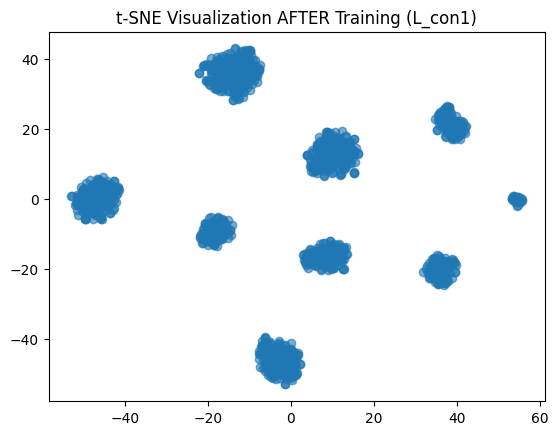

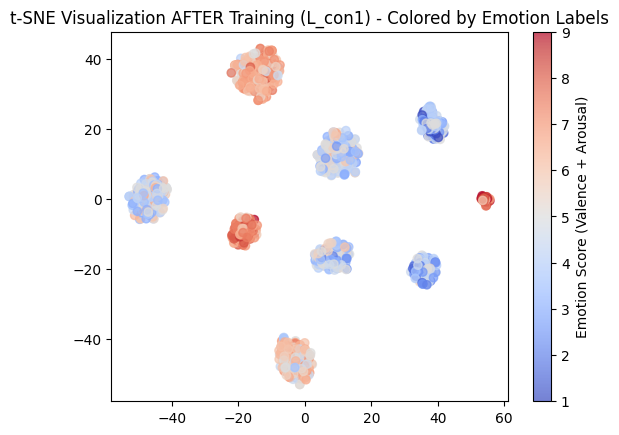

In [22]:
# Load trained model
cfe.load_state_dict(torch.load("cfe_trained.pth"))
cfe.eval()  # Set to evaluation mode

# Extract learned features after training
with torch.no_grad():
    post_training_features = cfe(pca_features_tensor.to(device))  # (1280, 64)
    post_training_features = post_training_features.cpu().numpy()  # Convert to NumPy


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
post_training_tsne = tsne.fit_transform(post_training_features)

# Scatter plot
plt.scatter(post_training_tsne[:, 0], post_training_tsne[:, 1], alpha=0.6)
plt.title("t-SNE Visualization AFTER Training (L_con1)")
plt.show()


import numpy as np

# Normalize emotion labels to [0,1]
emotion_scores = (valence_labels + arousal_labels) / 2  # Shape: (1280,)

plt.scatter(post_training_tsne[:, 0], post_training_tsne[:, 1], c=emotion_scores, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Emotion Score (Valence + Arousal)")
plt.title("t-SNE Visualization AFTER Training (L_con1) - Colored by Emotion Labels")
plt.show()


In [23]:
all_features = []
all_labels = []

cfe.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in dataloader:
        eeg_data, labels = batch
        eeg_data, labels = eeg_data.to(device), labels.to(device)
        
        # Extract features from trained model
        features = cfe(eeg_data)  
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

# Convert to numpy
all_features = torch.cat(all_features).numpy()
all_labels = torch.cat(all_labels).numpy()
np.save("post_training_features.npy", all_features)
np.save("post_training_labels.npy", all_labels)


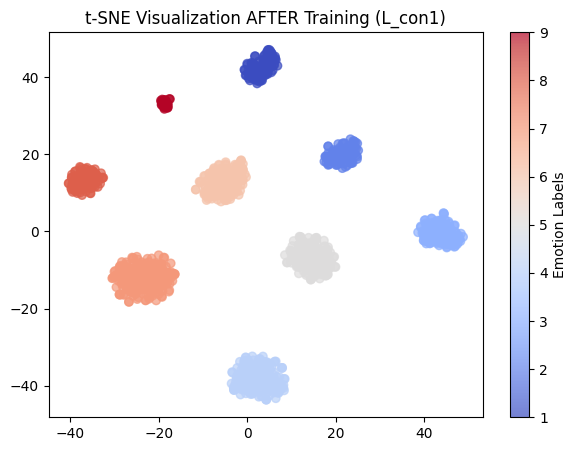

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load saved features
features = np.load("post_training_features.npy")
labels = np.load("post_training_labels.npy")

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

# Visualization
plt.figure(figsize=(7, 5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Emotion Labels")
plt.title("t-SNE Visualization AFTER Training (L_con1)")
plt.show()


**SUBJECT SPECIFIC FEATURE**

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SFE(nn.Module):
    def __init__(self, input_dim=64, output_dim=32):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return x

class SSC(nn.Module):
    def __init__(self, input_dim=32, num_classes=4):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # No activation after this
    
    def forward(self, x):
        x = self.fc(x)
        return x


In [26]:
sfe = SFE()
ssc = SSC()

# Generate random input data (batch_size=10, feature_dim=64)
random_input = torch.randn(64, 64)

# Pass through SFE
sfe_output = sfe(random_input)
print(f"SFE Output Shape: {sfe_output.shape}")  # Expected: (10, 32)

# Pass through SSC
ssc_output = ssc(sfe_output)
print(f"SSC Output Shape: {ssc_output.shape}")  # Expected: (10, 3)

SFE Output Shape: torch.Size([64, 32])
SSC Output Shape: torch.Size([64, 4])


**SUBJECT SPACE PROCEDURE**

In [66]:
import torch
import torch.nn.functional as F

def compute_rbf_kernel(x, y, gamma=None):
    """Computes RBF (Gaussian) kernel between two sets of features."""
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]

    # Compute pairwise squared distances
    xx = torch.matmul(x, x.T)
    yy = torch.matmul(y, y.T)
    xy = torch.matmul(x, y.T)

    x_norm = xx.diag().view(x_size, 1).expand(x_size, y_size)
    y_norm = yy.diag().view(1, y_size).expand(x_size, y_size)

    distances = x_norm + y_norm - 2 * xy

    if gamma is None:
        gamma = 1.0 / dim  # Default gamma

    return torch.exp(-gamma * distances)

class MMDLoss(nn.Module):
    """
    Maximum Mean Discrepancy (MMD) loss between source and target features.
    """
    def __init__(self, gamma=None):
        super(MMDLoss, self).__init__()
        self.gamma = gamma

    def forward(self, source_features, target_features):
        kernel_ss = compute_rbf_kernel(source_features, source_features, self.gamma)  # K(X^S, X^S)
        kernel_tt = compute_rbf_kernel(target_features, target_features, self.gamma)  # K(X^T, X^T)
        kernel_st = compute_rbf_kernel(source_features, target_features, self.gamma)  # K(X^S, X^T)

        # Compute MMD loss
        mmd = kernel_ss.mean() + kernel_tt.mean() - 2 * kernel_st.mean()
        return mmd


In [28]:
# Generate random source and target features
source_features = torch.randn(32, 32)  # (batch_size, feature_dim)
target_features = torch.randn(32, 32)

# Compute MMD loss
mmd_value = mmd_loss(source_features, target_features)
print(f"MMD Loss: {mmd_value.item():.4f}")


MMD Loss: 0.0501


**GCE IMPLEMENTATION**

In [171]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

class TruncatedLoss(nn.Module):

    def __init__(self, q=0.7, k=0.5, trainset_size=50000):
        super(TruncatedLoss, self).__init__()
        self.q = q
        self.k = k
        self.weight = torch.nn.Parameter(data=torch.ones(trainset_size, 1), requires_grad=False)
        
    def forward(self, logits, targets, indexes):
        p = F.softmax(logits, dim=1)

        # Ensure targets are class indices, not feature embeddings
        if targets.dim() > 1:  # If targets have extra dimensions (e.g., [128, 32]), fix it
            targets = targets[:, 0]  # Assuming first column has correct labels

        targets = targets.view(-1, 1).long().clamp(0, p.shape[1] - 1)  # Shape: [batch_size, 1]

        Yg = torch.gather(p, 1, targets)+ 1e-6

        indexes = torch.arange(logits.shape[0], device=logits.device)  # Ensure indexes are on the same device

        # **Modify weight in-place without reassignment**
        weight_device = self.weight.to(logits.device)  # Move weight to the same device for computation

        loss = ((1 - (Yg ** self.q)) / self.q) * weight_device[indexes] - ((1 - (self.k ** self.q)) / self.q) * weight_device[indexes]
        return torch.mean(loss)

             
    
    def update_weight(self, logits, targets, indexes):
        p = F.softmax(logits, dim=1)
        targets = targets.view(-1, 1).long().clamp(0, p.shape[1] - 1)
        Yg = torch.gather(p, 1, targets) +ie-6
        Lq = ((1-(Yg**self.q))/self.q)
        Lqk = np.repeat(((1-(self.k**self.q))/self.q), targets.size(0))
        Lqk = torch.from_numpy(Lqk).to(logits.device)
        Lqk = torch.unsqueeze(Lqk, 1)
        

        condition = torch.gt(Lqk, Lq)
        self.weight[indexes] = condition.type_as(self.weight)

        

In [30]:
# Initialize loss function
loss_fn = TruncatedLoss(q=0.7, k=0.5, trainset_size=50000)

# Example batch data
batch_size = 32
num_classes = 4
indexes = torch.randint(0, 50000, (batch_size,))  # Sample indices
logits = torch.randn(batch_size, num_classes)  # Model predictions
targets = torch.randint(0, num_classes, (batch_size,))  # Ground truth labels

# Compute loss
loss_value = loss_fn(logits, targets, indexes)
print(f"Loss: {loss_value.item():.4f}")

# Update weights
loss_fn.update_weight(logits, targets, indexes)


Loss: 0.4075


**CONTRASTIVE LOSS FUNCTION 2**

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PrototypeMemory:
    def __init__(self, num_classes=4, feature_dim=32, momentum=0.9):
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        self.momentum = momentum
        self.prototypes = torch.zeros(num_classes, feature_dim, device=torch.device("cuda"), requires_grad=False)


    def update(self, features, labels):
        """
        Update prototype vectors using moving average rule.
        """
        for c in range(self.num_classes):
            class_mask = (labels == c)
            if class_mask.sum() > 0:
                class_features = F.normalize(features[class_mask].mean(dim=0), dim=0)  # Normalize before update
                self.prototypes[c] = F.normalize(
                    self.momentum * self.prototypes[c] + (1 - self.momentum) * class_features, dim=0
                )

    def get_prototype(self, labels):
        """
        Retrieve prototype vectors for given labels.
        """
        return self.prototypes[labels]  # No loop needed, supports batch indexing

In [120]:
class FeatureQueue:
    def __init__(self, feature_dim=32, queue_size=1024):
        self.queue_size = queue_size
        self.feature_dim = feature_dim
        self.queue = torch.zeros(queue_size, feature_dim).cuda()
        self.ptr = 0  # Pointer to track queue position
        self.filled = 0  # Tracks how much queue is filled

    def enqueue(self, features):
        """
        Add new features to the queue in a FIFO manner.
        """
        batch_size = features.shape[0]
        if batch_size > self.queue_size:
            self.queue = features[-self.queue_size:]  # Keep only the most recent
            self.filled = self.queue_size
        else:
            end_ptr = (self.ptr + batch_size) % self.queue_size
            if end_ptr < self.ptr:  # Overwrite case
                self.queue[self.ptr:] = features[: self.queue_size - self.ptr]
                self.queue[:end_ptr] = features[self.queue_size - self.ptr :]
            else:
                self.queue[self.ptr:end_ptr] = features
            self.ptr = end_ptr
            self.filled = min(self.queue_size, self.filled + batch_size)

    def get_queue(self):
        """
        Retrieve all stored features.
        """
        return self.queue[: self.filled]  # Return only filled part of the queue

In [121]:
def assign_pseudo_labels(logits, features, confidence_threshold=0.5):
    """
    Assign pseudo labels based on high-confidence predictions.
    """
    probs = F.softmax(logits, dim=1)
    max_probs, pseudo_labels = torch.max(probs, dim=1)
    
    mask = max_probs > confidence_threshold  # Only keep high-confidence samples
    return pseudo_labels[mask], features[mask], mask  # Also return the mask


In [142]:
class ContrastiveLoss2(nn.Module):
    def __init__(self, tau=0.07):
        super().__init__()
        self.tau = tau

    def forward(self, target_features, pseudo_labels, prototype_memory, feature_queue):
        """
        Computes L_con2 loss.
        """
        batch_size = target_features.shape[0]
        queue_features = feature_queue.get_queue()
        if queue_features.shape[0] > 0:  # Ensure there are features in the queue
            all_features = torch.cat([queue_features, prototype_memory.prototypes], dim=0)
        else:
            all_features = prototype_memory.prototypes  # Use only prototypes if queue is empty

        # all_features = torch.cat([feature_queue.get_queue(), prototype_memory.prototypes], dim=0)  # Add prototypes
        all_features = F.normalize(all_features, dim=1)  # Ensure normalization
        
        # Get corresponding prototypes
        proto_vectors = prototype_memory.get_prototype(pseudo_labels)
        
        # Compute positive pair similarity
        positive_logits = (target_features * proto_vectors).sum(dim=1) / self.tau
        positive_exp = torch.exp(positive_logits)

        # Compute negative pair similarities
        negative_logits = (target_features @ all_features.T) / self.tau
        negative_exp = torch.exp(negative_logits).sum(dim=1)

        # Compute contrastive loss
        loss = -torch.log(positive_exp / negative_exp).mean()
        return loss

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class HybridLoss(nn.Module):
    def __init__(self, truncated_loss, alpha=0.1, transition_epoch=50):
        """
        Hybrid loss function with dynamic weightage.

        Args:
        - truncated_loss: Instance of TruncatedLoss
        - alpha: Controls transition speed
        - transition_epoch: Epoch at which Truncated Loss and CE Loss start balancing
        """
        super(HybridLoss, self).__init__()
        self.truncated_loss = truncated_loss
        self.ce_loss = nn.CrossEntropyLoss()
        self.alpha = alpha
        self.transition_epoch = transition_epoch

    def get_dynamic_weights(self, current_epoch):
        """
        Compute dynamic weightage for truncated loss and classification loss.

        Args:
        - current_epoch: Current training epoch

        Returns:
        - lambda_1 (weight for Truncated Loss)
        - lambda_2 (weight for Cross-Entropy Loss)
        """
        lambda_1 = 1 / (1 + math.exp(-self.alpha * (current_epoch - self.transition_epoch)))
        lambda_2 = 1 - lambda_1
        return lambda_1, lambda_2

    def forward(self, logits, targets, indexes, current_epoch):
        """
        Compute the Hybrid Loss with dynamic weightage.

        Args:
        - logits: Model predictions (before softmax)
        - targets: True labels
        - indexes: Sample indices (for Truncated Loss weight update)
        - current_epoch: Current epoch number

        Returns:
        - Hybrid loss value
        """
        lambda_1, lambda_2 = self.get_dynamic_weights(current_epoch)
        loss_truncated = self.truncated_loss(logits, targets, indexes)
        loss_classification = self.ce_loss(logits, targets)
        
        loss = lambda_1 * loss_truncated + lambda_2 * loss_classification
        return loss


**TRAINING PIPELINE**

In [144]:
import torch

# Convert to PyTorch tensors
pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32)
pca_features_tensor = pca_features_tensor.view(-1, 1000)  # Reshape to (1280, 1000)

# Ensure labels are also tensors
# Flatten labels from (32, 40, 4) → (1280, 4)
labels_tensor = torch.tensor(subject_labels, dtype=torch.float32).reshape(1280, 4)# Adjust `subject_labels` as needed


In [145]:
print("PCA Features Shape:", pca_features_tensor.shape)  
print("Labels Shape:", labels_tensor.shape)  


PCA Features Shape: torch.Size([1280, 1000])
Labels Shape: torch.Size([1280, 4])


In [146]:
print("PCA Features Shape:", pca_features_tensor.shape)  # Should be (1280, 1000)
print("Labels Shape:", labels_tensor.shape)  # Should be (1280, 4)
print("First Dim Match:", pca_features_tensor.shape[0] == labels_tensor.shape[0])


PCA Features Shape: torch.Size([1280, 1000])
Labels Shape: torch.Size([1280, 4])
First Dim Match: True


In [147]:
print("PCA Features Type:", pca_features_tensor.dtype)
print("Labels Type:", labels_tensor.dtype)


PCA Features Type: torch.float32
Labels Type: torch.float32


In [148]:
from torch.utils.data import DataLoader, TensorDataset

# Create Dataset
dataset = TensorDataset(pca_features_tensor, labels_tensor)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)


**TRAINING ON REAL DATA**

In [180]:
import torch
import torch.optim as optim

def compute_dynamic_weights(epoch, num_epochs=100):
    """Compute dynamic weights α and β for loss balancing."""
    alpha = 2 / (1 + torch.exp(torch.tensor(-10 * (epoch / num_epochs), dtype=torch.float32))) - 1
    beta = alpha / 100
    alpha = min(alpha,0.658)
    beta = min(beta,0.00658)
    return alpha, beta

def train_pipeline(cfe, sfe, ssc, 
                   contrastive_loss1, contrastive_loss2, hybrid_loss, mmd_loss,
                   train_loader_source, train_loader_target, 
                   prototype_memory, feature_queue,
                   optimizer, num_epochs=100, device="cuda"):

    # Move models to device
    cfe.to(device)
    sfe.to(device)
    ssc.to(device)

    for epoch in range(num_epochs):
        total_loss = 0.0

        # Compute dynamic weighting coefficients α and β
        alpha, beta = compute_dynamic_weights(epoch, num_epochs)

        for (source_data, source_labels), (target_data,) in zip(train_loader_source, train_loader_target):
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)

            # 1️⃣ **Common Feature Extraction (CFE)**
            source_features = cfe(source_data)
            # print("CFE Output Shape:", source_features.shape)
            target_features = cfe(target_data)
            # print("CFE Output Shape:", target_features.shape)

            # 2️⃣ **Subject-Specific Feature Mapping (SFE)**
            source_features_mapped = sfe(source_features)
            # print("SFE Output Shape (to SSC):", source_features_mapped.shape)
            target_features_mapped = sfe(target_features)

            # 3️⃣ **Contrastive Loss 1 (L_con1) for Common Space**
            loss_con1 = contrastive_loss1(source_features_mapped, target_features_mapped)

            # 4️⃣ **MMD Loss for Subject-Specific Subspaces**
            loss_mmd = mmd_loss(source_features_mapped, target_features_mapped)

            # 5️⃣ **Contrastive Loss 2 (L_con2) for Class Information**
            logits = ssc(target_features_mapped)
            # print("Logits Shape:", logits.shape)
            # print("Target Features Shape:", target_features_mapped.shape)

            pseudo_labels, filtered_features, mask = assign_pseudo_labels(logits, target_features_mapped, confidence_threshold=0.2)
            # print("Pseudo Labels Shape:", pseudo_labels.shape)
            # print("Filtered Features Shape:", filtered_features.shape)
            # print(f"Mask Shape: {mask.shape}, Number of Confident Samples: {mask.sum().item()}")


            loss_con2 = torch.tensor(0.0, device=device)  # Default loss if no confident samples
            if mask.sum() > 0:  # Ensure we have high-confidence samples
                loss_con2 = contrastive_loss2(target_features_mapped[mask], pseudo_labels, prototype_memory, feature_queue)

            # 6️⃣ **Hybrid Classification Loss**
            source_logits = ssc(source_features_mapped)
            indexes = torch.arange(source_labels.size(0), device=device)  # Batch indices
            loss_hybrid = hybrid_loss(source_logits, source_labels, indexes, epoch)

            # 7️⃣ **Compute Total Loss with Dynamic Weights**
            total_loss_batch = loss_hybrid + alpha * loss_mmd + beta * (loss_con1 + loss_con2)

            # 8️⃣ **Backpropagation & Optimization**
            optimizer.zero_grad()
            total_loss_batch.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # ✅ **Update Prototype Memory & Feature Queue**
            with torch.no_grad():
                prototype_memory.update(target_features_mapped, pseudo_labels)
                feature_queue.enqueue(target_features_mapped)

            total_loss += total_loss_batch.detach()  # Avoid unnecessary `.item()` calls

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, α: {alpha:.4f}, β: {beta:.4f}")

    print("✅ Training Complete!")


In [181]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assume PCA features are (1280, 1000) and labels are (1280,)
num_samples = pca_features_tensor.shape[0]
num_source_samples = int(0.8 * num_samples)  # 80% source, 20% target

# Split into source (labeled) and target (unlabeled)
source_features = pca_features_tensor[:num_source_samples]  # First 80% for source
source_labels = labels_tensor[:num_source_samples]  # Corresponding labels

target_features = pca_features_tensor[num_source_samples:]  # Last 20% for target
# No labels for the target domain (unsupervised)

# Create TensorDatasets
source_dataset = TensorDataset(source_features, source_labels)
target_dataset = TensorDataset(target_features)  # Target has only features

# Create DataLoaders
train_loader_source = DataLoader(source_dataset, batch_size=128, shuffle=True)
train_loader_target = DataLoader(target_dataset, batch_size=128, shuffle=True)


In [183]:
# Instantiate your models
cfe = CommonFeatureExtractor().to("cuda")
sfe = SFE().to("cuda")
ssc = SSC(input_dim=32, num_classes=4).to("cuda")  # Adjust input_dim if needed

# Instantiate loss functions
contrastive_loss1 = ContrastiveLossLcon1()
contrastive_loss2 = ContrastiveLoss2()
truncated_loss = TruncatedLoss()  # Ensure this class is defined
hybrid_loss = HybridLoss(truncated_loss)
mmd_loss = MMDLoss()  # Ensure you have this implemented

# Create prototype memory and feature queue
prototype_memory = PrototypeMemory()
feature_queue = FeatureQueue()

# Define optimizer
optimizer = optim.Adam(list(cfe.parameters()) + list(sfe.parameters()) + list(ssc.parameters()), lr=5e-5)

# Load real EEG data from DataLoader
train_pipeline(
    cfe=cfe,
    sfe=sfe,
    ssc=ssc,
    contrastive_loss1=contrastive_loss1,
    contrastive_loss2=contrastive_loss2,
    hybrid_loss=hybrid_loss,
    mmd_loss=mmd_loss,
    train_loader_source=train_loader_source,
    train_loader_target=train_loader_target,
    prototype_memory=prototype_memory,
    feature_queue=feature_queue,
    optimizer=optimizer,
    num_epochs=100,  # Adjust based on needs
    device="cuda"
)


Epoch [1/100], Loss: 58.6706, α: 0.0000, β: 0.0000
Epoch [2/100], Loss: 58.7577, α: 0.0500, β: 0.0005
Epoch [3/100], Loss: 58.7807, α: 0.0997, β: 0.0010
Epoch [4/100], Loss: 58.3920, α: 0.1489, β: 0.0015
Epoch [5/100], Loss: 59.1620, α: 0.1974, β: 0.0020
Epoch [6/100], Loss: 60.0158, α: 0.2449, β: 0.0024
Epoch [7/100], Loss: 59.1296, α: 0.2913, β: 0.0029
Epoch [8/100], Loss: 57.6738, α: 0.3364, β: 0.0034
Epoch [9/100], Loss: 57.8687, α: 0.3799, β: 0.0038
Epoch [10/100], Loss: 58.4845, α: 0.4219, β: 0.0042
Epoch [11/100], Loss: 57.7654, α: 0.4621, β: 0.0046
Epoch [12/100], Loss: 55.8918, α: 0.5005, β: 0.0050
Epoch [13/100], Loss: 59.1041, α: 0.5370, β: 0.0054
Epoch [14/100], Loss: 56.8125, α: 0.5717, β: 0.0057
Epoch [15/100], Loss: 57.9831, α: 0.6044, β: 0.0060
Epoch [16/100], Loss: 56.6764, α: 0.6351, β: 0.0064
Epoch [17/100], Loss: 58.4765, α: 0.6580, β: 0.0066
Epoch [18/100], Loss: 57.2619, α: 0.6580, β: 0.0066
Epoch [19/100], Loss: 56.5149, α: 0.6580, β: 0.0066
Epoch [20/100], Loss: